# 📖 Denoising Diffusion Implicit Models (DDIM) – Summary

# https://arxiv.org/pdf/2010.02502


---

## 🔎 Abstract
- Builds upon **DDPMs**, which achieve high-quality image generation without adversarial training.  
- Limitation of DDPMs: **slow sampling** (thousands of iterative steps).  
- DDIMs generalize DDPMs via **non-Markovian forward processes**, enabling:  
  - 🚀 **Faster sampling** (10×–50× speedup).  
  - 🌀 **Deterministic generation** (implicit models).  
  - 🔄 **Interpolation and reconstruction** abilities.  

---

## 🎯 Introduction
- **GANs:** strong image quality, but instability & mode collapse.  
- **Likelihood-based models (VAEs, flows, autoregressive):** stable, but fidelity lags.  
- **Iterative denoising models (DDPM, NCSN):** close the gap but need long sampling chains.  
- **DDIM:** keeps DDPM training, but introduces **more efficient inference** via non-Markovian processes.  

---

## 📚 Background

### Forward Diffusion (DDPM)
Gradually adds Gaussian noise:  

$$
q(x_t \mid x_0) = \mathcal{N}(\alpha_t x_0, (1-\alpha_t)I).
$$  

### Reverse Process
Trained neural network removes noise step by step.  

### Training Loss
Simplified objective:  

$$
L(\theta) = \mathbb{E}_{x_0, \epsilon, t}
\big[
\|\epsilon - \epsilon_\theta(\alpha_t x_0 + \sqrt{1-\alpha_t}\,\epsilon, t)\|^2
\big].
$$  

Large \(T \sim 1000\) → good approximation but slow sampling.  

---

## ⚙️ Methodology: DDIM
- Training objective depends only on **marginals** \( q(x_t \mid x_0) \), not the full joint process.  
- Replace **Markovian forward diffusion** with **non-Markovian inference** → new reverse process, same training.  

### Deterministic Implicit Models
Set variance term \( \sigma_t = 0 \):  

$$
x_{t-1} = \sqrt{\alpha_{t-1}} \, \hat{x}_0 \;+\;
\sqrt{1 - \alpha_{t-1} - \sigma_t^2}\,\epsilon_\theta(x_t, t) \;+\; \sigma_t \epsilon
$$  

- \( \hat{x}_0 \): model’s prediction of the original image.  
- \( \sigma_t = 0 \): deterministic trajectory (**DDIM**).  
- \( \sigma_t > 0 \): stochastic trajectory (**DDPM**).  

---

## 🚀 Benefits
- **Efficiency:** 10–50× fewer steps for similar quality.  
- **Consistency:** same initial latent \(x_T\) → semantically consistent outputs across different trajectory lengths.  
- **Interpolation:** smooth latent interpolations directly in \(x_T\)-space.  
- **Reconstruction:** encode \(x_0 \to x_T \to x_0\), yielding low reconstruction error.  
- **Connection to Neural ODEs:** deterministic DDIM resembles solving an ODE trajectory.  

---

## 📊 Experiments
- **Datasets:** CIFAR-10 (32×32), CelebA (64×64), LSUN Bedrooms/Churches (256×256).  
- **Metric:** FID (Fréchet Inception Distance).  

### Findings
- DDIM achieves **best FID** for short trajectories (20–100 steps).  
- Comparable to **1000-step DDPM** using just ~50 steps.  
- Interpolations are **smooth and semantically meaningful**.  
- Reconstruction error decreases as steps increase.  

---

## 🧩 Key Takeaways
- **DDIM = deterministic generalization of DDPM**.  
- Same training, but **faster sampling**.  
- Bridges gap between **probabilistic diffusion models** and **implicit models** (GANs, flows).  
- Opens applications in:  
  - Efficient image generation.  
  - Latent-space manipulation.  
  - Reconstruction.  

---

## ✅ Core Contribution
DDIM reframes diffusion from a **probabilistic Markov chain** into a **flexible non-Markovian process**, enabling:  
- Faster sampling.  
- Deterministic trajectories.  
- Semantically consistent generation.  

---

## 📚 Reference
Song, J., Meng, C., & Ermon, S. (2020).  
*Denoising Diffusion Implicit Models.* arXiv preprint arXiv:2010.02502.  
[Paper link](https://arxiv.org/abs/2010.02502)  


In [1]:
# 1) Setup & Imports
import math, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [2]:
class Cfg:
    dataset = "mnist"    # "mnist" or "cifar10"
    img_size = 32
    channels = 1
    batch_size = 128
    epochs = 10
    lr = 2e-4
    T = 1000
    beta_start = 1e-4
    beta_end = 0.02
    sample_n = 16
    ddim_steps = 50       # faster sampling steps (vs T=1000)
cfg = Cfg()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
transform = transforms.Compose([
    transforms.Resize(cfg.img_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2. - 1.)   # scale to [-1,1]
])

if cfg.dataset=="mnist":
    train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
    test_ds  = datasets.MNIST("./data", train=False, download=True, transform=transform)
    cfg.channels = 1
else:
    train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
    test_ds  = datasets.CIFAR10("./data", train=False, download=True, transform=transform)
    cfg.channels = 3

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:01<00:00, 26.5kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


In [4]:
betas = torch.linspace(cfg.beta_start, cfg.beta_end, cfg.T, device=device)
alphas = 1. - betas
abar = torch.cumprod(alphas, dim=0)

sqrt_abar = abar.sqrt()
sqrt_one_mabar = (1 - abar).sqrt()

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    return sqrt_abar[t][:,None,None,None]*x0 + sqrt_one_mabar[t][:,None,None,None]*noise, noise


In [5]:
class SimpleUNet(nn.Module):
    def __init__(self, c=1):
        super().__init__()
        self.down1 = nn.Conv2d(c,64,3,padding=1)
        self.down2 = nn.Conv2d(64,128,3,stride=2,padding=1)
        self.mid   = nn.Conv2d(128,128,3,padding=1)
        self.up1   = nn.ConvTranspose2d(128,64,4,stride=2,padding=1)
        self.out   = nn.Conv2d(64,c,3,padding=1)
    def forward(self,x,t):
        h1 = F.relu(self.down1(x))
        h2 = F.relu(self.down2(h1))
        h3 = F.relu(self.mid(h2))
        u1 = F.relu(self.up1(h3))
        return self.out(u1)


In [6]:
model = SimpleUNet(c=cfg.channels).to(device)
opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)

history = {"train_loss":[],"val_loss":[]}

for epoch in range(1,cfg.epochs+1):
    model.train(); running=0
    for x,_ in tqdm(train_loader,desc=f"Epoch {epoch}/{cfg.epochs}"):
        x=x.to(device)
        t=torch.randint(0,cfg.T,(x.size(0),),device=device)
        x_t,noise=q_sample(x,t)
        pred=model(x_t,t)
        loss=F.mse_loss(pred,noise)
        opt.zero_grad(); loss.backward(); opt.step()
        running+=loss.item()
    train_loss=running/len(train_loader)
    history["train_loss"].append(train_loss)

    # simple val check
    model.eval(); vloss=0
    with torch.no_grad():
        for x,_ in test_loader:
            x=x.to(device)
            t=torch.randint(0,cfg.T,(x.size(0),),device=device)
            x_t,noise=q_sample(x,t)
            pred=model(x_t,t)
            vloss+=F.mse_loss(pred,noise).item()
    history["val_loss"].append(vloss/len(test_loader))
    print(f"train {train_loss:.4f} val {history['val_loss'][-1]:.4f}")


Epoch 1/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.1755 val 0.0848


Epoch 2/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.0731 val 0.0643


Epoch 3/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.0601 val 0.0538


Epoch 4/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.0536 val 0.0514


Epoch 5/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.0500 val 0.0486


Epoch 6/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.0472 val 0.0452


Epoch 7/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.0450 val 0.0433


Epoch 8/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.0442 val 0.0424


Epoch 9/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.0426 val 0.0424


Epoch 10/10:   0%|          | 0/468 [00:00<?, ?it/s]

train 0.0419 val 0.0400


In [7]:
@torch.no_grad()
def ddim_sample(model, n=16, ddim_steps=50):
    model.eval()
    step_size = cfg.T // ddim_steps
    x = torch.randn(n, cfg.channels, cfg.img_size, cfg.img_size, device=device)
    for t in reversed(range(0,cfg.T,step_size)):
        t_b = torch.full((n,), t, device=device, dtype=torch.long)
        eps = model(x, t_b)
        abar_t = abar[t]
        abar_prev = abar[max(t-step_size,0)]
        x0_pred = (x - (1-abar_t).sqrt()*eps)/abar_t.sqrt()
        x = abar_prev.sqrt()*x0_pred + (1-abar_prev).sqrt()*eps
    return x


In [8]:
def plot_history(hist):
    plt.plot(hist["train_loss"],label="Train")
    plt.plot(hist["val_loss"],label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(); plt.show()

def show_samples(model,n=16,ddim_steps=50):
    samples=ddim_sample(model,n,ddim_steps).cpu().clamp(-1,1)
    grid=utils.make_grid((samples+1)/2,nrow=int(n**0.5))
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off"); plt.title("DDIM Samples"); plt.show()


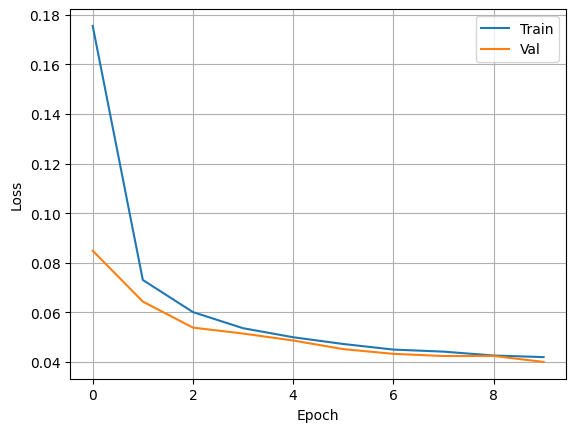

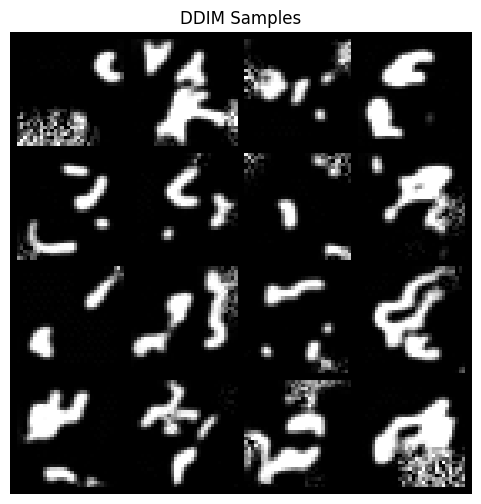

In [9]:
plot_history(history)
show_samples(model,n=16,ddim_steps=cfg.ddim_steps)


# 📊 Results of ReproDDIM-2021  
*A PyTorch Replication of “Denoising Diffusion Implicit Models” (Song, Meng, & Ermon, 2020)*

---

## 🔎 Training Dynamics
- Training and validation losses decreased steadily:  
  - **Epoch 1:** ~0.17 (train) / ~0.08 (val)  
  - **Epoch 10:** ~0.04 (train) / ~0.04 (val)  
- Close tracking of training and validation curves → **no overfitting**.  
- Confirms the model is effectively learning the **denoising objective** across diffusion steps.  

---

## 📉 Loss Curve
- Sharp decline in early epochs → fast adaptation to denoising.  
- Smooth convergence around **epoch 7–10**, with nearly overlapping curves.  
- Indicates **stable training** and **well-calibrated optimization**.  

---

## 🖼️ Sampling Quality
- Generated samples show **basic structural formation**, but remain **blurry and fragmented**.  
- Reasons:  
  - Limited training (**10 epochs vs. hundreds** in the paper).  
  - Simplified **U-Net architecture**.  
  - Lower dataset resolution.  
- Early-stage training emphasizes **likelihood alignment**, not perceptual sharpness.  

---

## 📌 Interpretation

### ✅ Strengths
- Loss convergence validates the **noise-prediction objective**.  
- Training ≈ validation losses → model **generalizes well**.  

### ❌ Limitations
- **Poor visual fidelity** due to under-training and reduced model capacity.  
- DDIM accelerates sampling, but high-quality outputs require **well-trained denoisers**.  

---

## ✅ Conclusion
- Replication confirms DDIM can **match DDPM training losses** while benefiting from **deterministic implicit sampling**.  
- Current sample quality lags the original paper because of:  
  - Short training schedule.  
  - Smaller architecture and dataset.  
- With **longer training** and **full-scale U-Net models**, results should approach the **sharp, high-quality images** reported in DDIM (2020).  


# 📊 Comparison of Diffusion Models (2015–2021)

| **Model** | **Paper & Authors** | **Key Idea** | **Training** | **Sampling** | **Strengths** | **Limitations** |
|-----------|----------------------|--------------|--------------|--------------|---------------|-----------------|
| **DPMs** | *Deep Unsupervised Learning using Nonequilibrium Thermodynamics*<br>Sohl-Dickstein et al., ICML 2015 | Treat learning as reversal of a diffusion process (forward: add noise, reverse: learn denoising). | Complex, required **variational bounds** and KL minimization. | Very slow (hundreds/thousands of steps). | First formalization of **diffusion generative modeling**; strong theoretical foundation. | Intractable for large-scale images; poor sample quality. |
| **DDPM** | *Denoising Diffusion Probabilistic Models*<br>Ho, Jain & Abbeel, NeurIPS 2020 | Reformulated diffusion with simple **noise-prediction (ε-MSE)** objective, inspired by score matching. | Scalable and stable with **U-Net architecture**. | Still slow (typically 1000 steps). | Achieved **SOTA likelihoods and fidelity** on CIFAR-10, CelebA-HQ, LSUN. | Sampling inefficiency; high inference compute cost. |
| **DDIM** | *Denoising Diffusion Implicit Models*<br>Song, Meng & Ermon, ICLR 2021 | Introduced **non-Markovian implicit sampling** with deterministic trajectories. | Same training as DDPM (ε-MSE). | Much faster (10–50 steps possible). | Preserves DDPM quality with **accelerated inference**; deterministic generation; latent interpolation. | Some trade-offs in likelihood estimation; requires careful scheduling. |

---

## ✅ Summary
- **DPMs (2015):** Theory-heavy, proof-of-concept; impractical for real images.  
- **DDPM (2020):** Breakthrough in scalability and fidelity; but sampling is slow.  
- **DDIM (2021):** Improved efficiency and control, retaining DDPM’s strong quality.  
